In [17]:
from geotessera import GeoTessera
import numpy as np

# Initialize the client
gt = GeoTessera()

# Method 1: Fetch a single tile
embedding, crs, transform = gt.fetch_embedding(lon=0.15, lat=52.05, year=2024)
print(f"Shape: {embedding.shape}")  # e.g., (1200, 1200, 128)
print(f"CRS: {crs}")  # Coordinate reference system from landmask

# Method 2: Fetch all tiles in a bounding box

bbox = (-1.671467,42.804532,-1.599112,42.838276)  # (min_lon, min_lat, max_lon, max_lat)
tiles_to_fetch = gt.registry.load_blocks_for_region(bounds=bbox, year=2024)
embeddings = gt.fetch_embeddings(tiles_to_fetch)

for year, tile_lon, tile_lat, embedding_array, crs, transform in embeddings:
    print(f"Tile ({tile_lat}, {tile_lon}): {embedding_array.shape}")

Could not check for updates: [WinError 183] No se puede crear un archivo que ya existe: 'C:\\Users\\2012m\\AppData\\Local\\geotessera\\.registry.parquet_tmp_aqzdhor9.parquet' -> 'C:\\Users\\2012m\\AppData\\Local\\geotessera\\registry.parquet'
Could not check for landmasks updates: [WinError 183] No se puede crear un archivo que ya existe: 'C:\\Users\\2012m\\AppData\\Local\\geotessera\\.landmasks.parquet_tmp_ms13316y.parquet' -> 'C:\\Users\\2012m\\AppData\\Local\\geotessera\\landmasks.parquet'


Shape: (1139, 729, 128)
CRS: EPSG:32631
Tile (42.85, -1.65): (1124, 835, 128)
Tile (42.85, -1.55): (1125, 836, 128)


## Clustering Analysis

Perform K-means clustering on the embeddings and visualize the results.

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare embeddings for clustering
# Flatten the spatial dimensions and keep only the embedding dimension
# Shape: (1200, 1200, 128) -> (1200*1200, 128)
embeddings_flat = embedding.reshape(-1, embedding.shape[-1])

print(f"Embeddings shape for clustering: {embeddings_flat.shape}")
print(f"Total pixels: {embeddings_flat.shape[0]}")

Embeddings shape for clustering: (830331, 128)
Total pixels: 830331


In [19]:
# Perform K-means clustering
n_clusters = 5
print(f"Performing K-means clustering with {n_clusters} clusters...")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings_flat)

# Reshape labels back to spatial dimensions
cluster_map = cluster_labels.reshape(embedding.shape[0], embedding.shape[1])

print(f"Clustering completed!")
print(f"Cluster distribution: {np.bincount(cluster_labels)}")

Performing K-means clustering with 5 clusters...
Clustering completed!
Cluster distribution: [149600  99623  78776 277545 224787]


Performing PCA for 2D visualization...


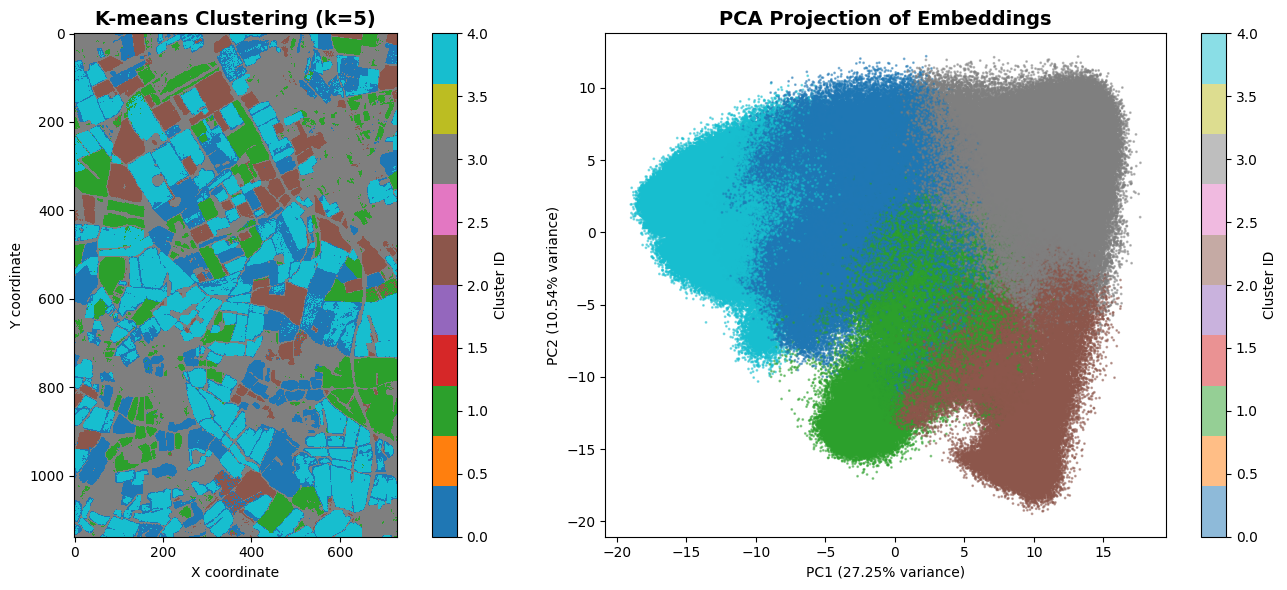


Total explained variance: 37.79%


In [20]:
# Visualize the clustering result
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Cluster map
im1 = axes[0].imshow(cluster_map, cmap='tab10', interpolation='nearest')
axes[0].set_title(f'K-means Clustering (k={n_clusters})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X coordinate')
axes[0].set_ylabel('Y coordinate')
plt.colorbar(im1, ax=axes[0], label='Cluster ID')

# Plot 2: PCA visualization of clusters
print("Performing PCA for 2D visualization...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_flat)

scatter = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                          c=cluster_labels, cmap='tab10', 
                          alpha=0.5, s=1)
axes[1].set_title('PCA Projection of Embeddings', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[1], label='Cluster ID')

plt.tight_layout()
plt.show()

print(f"\nTotal explained variance: {sum(pca.explained_variance_ratio_):.2%}")

## Clustering Analysis for BBox (Multiple Tiles)

Process and cluster embeddings from all tiles in the bounding box.

In [22]:
# Collect all embeddings from the bounding box
bbox_embeddings_list = []
tile_info = []

# Re-fetch embeddings from bbox (since generator was already consumed)
tiles_to_fetch = gt.registry.load_blocks_for_region(bounds=bbox, year=2024)
embeddings_gen = gt.fetch_embeddings(tiles_to_fetch)

print("Collecting embeddings from all tiles in bounding box...")
for year, tile_lon, tile_lat, embedding_array, crs, transform in embeddings_gen:
    print(f"Processing tile ({tile_lat:.2f}, {tile_lon:.2f}): {embedding_array.shape}")
    # Flatten spatial dimensions: (H, W, 128) -> (H*W, 128)
    flat_emb = embedding_array.reshape(-1, embedding_array.shape[-1])
    bbox_embeddings_list.append(flat_emb)
    tile_info.append({
        'lat': tile_lat,
        'lon': tile_lon,
        'shape': embedding_array.shape,
        'n_pixels': flat_emb.shape[0]
    })

# Concatenate all embeddings
bbox_embeddings_all = np.vstack(bbox_embeddings_list)

print(f"\n✓ Total embeddings collected: {bbox_embeddings_all.shape}")
print(f"✓ Number of tiles: {len(bbox_embeddings_list)}")
print(f"✓ Total pixels across all tiles: {bbox_embeddings_all.shape[0]:,}")

Processing tile (42.85, -1.65): (1124, 835, 128)
Processing tile (42.85, -1.55): (1125, 836, 128)

✓ Total embeddings collected: (1879040, 128)
✓ Number of tiles: 2
✓ Total pixels across all tiles: 1,879,040


In [23]:
# Perform K-means clustering on all bbox embeddings
n_clusters_bbox = 6
print(f"Performing K-means clustering on all tiles with {n_clusters_bbox} clusters...")

kmeans_bbox = KMeans(n_clusters=n_clusters_bbox, random_state=42, n_init=10, verbose=1)
cluster_labels_bbox = kmeans_bbox.fit_predict(bbox_embeddings_all)

print(f"\n✓ Clustering completed!")
print(f"Cluster distribution:")
for i, count in enumerate(np.bincount(cluster_labels_bbox)):
    print(f"  Cluster {i}: {count:,} pixels ({count/len(cluster_labels_bbox)*100:.2f}%)")

Performing K-means clustering on all tiles with 6 clusters...
Initialization complete
Iteration 0, inertia 826143232.0.
Iteration 1, inertia 524665440.0.
Iteration 2, inertia 509203520.0.
Iteration 3, inertia 500689408.0.
Iteration 4, inertia 496345920.0.
Iteration 5, inertia 493996288.0.
Iteration 6, inertia 492213408.0.
Iteration 7, inertia 490012352.0.
Iteration 8, inertia 486871808.0.
Iteration 9, inertia 484495616.0.
Iteration 10, inertia 483389280.0.
Iteration 11, inertia 482896928.0.
Iteration 12, inertia 482667776.0.
Iteration 13, inertia 482552032.0.
Iteration 14, inertia 482491264.0.
Iteration 15, inertia 482454464.0.
Iteration 16, inertia 482434496.0.
Iteration 17, inertia 482422848.0.
Iteration 18, inertia 482413824.0.
Iteration 19, inertia 482406752.0.
Iteration 20, inertia 482402688.0.
Iteration 21, inertia 482399520.0.
Iteration 22, inertia 482398624.0.
Iteration 23, inertia 482396928.0.
Iteration 24, inertia 482397120.0.
Iteration 25, inertia 482396448.0.
Iteration 26, 

In [24]:
# Reconstruct cluster maps for each tile
cluster_maps_per_tile = []
start_idx = 0

for tile in tile_info:
    n_pixels = tile['n_pixels']
    tile_labels = cluster_labels_bbox[start_idx:start_idx + n_pixels]
    # Reshape back to spatial dimensions
    h, w = tile['shape'][0], tile['shape'][1]
    tile_cluster_map = tile_labels.reshape(h, w)
    cluster_maps_per_tile.append(tile_cluster_map)
    start_idx += n_pixels

print(f"✓ Created cluster maps for {len(cluster_maps_per_tile)} tiles")

✓ Created cluster maps for 2 tiles


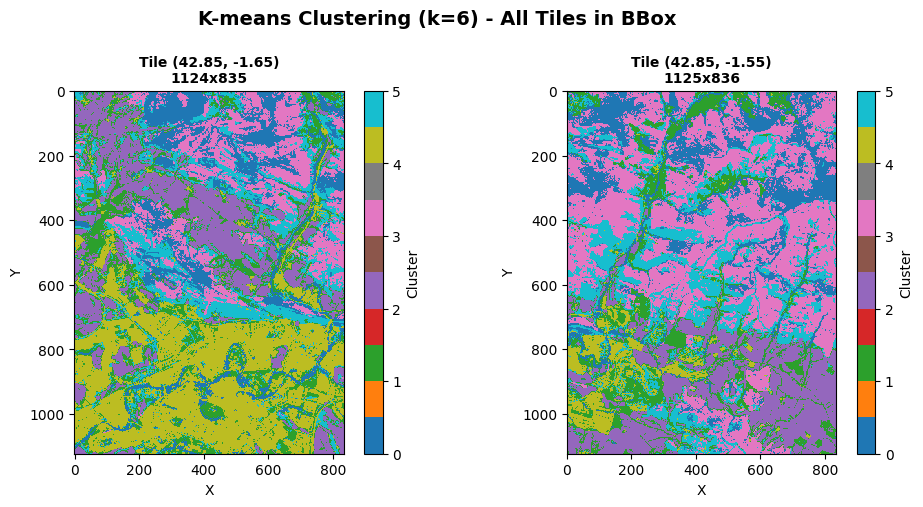

In [25]:
# Visualize cluster maps for all tiles
n_tiles = len(cluster_maps_per_tile)
cols = min(3, n_tiles)
rows = (n_tiles + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
if n_tiles == 1:
    axes = np.array([axes])
axes = axes.flatten()

for idx, (cluster_map, tile) in enumerate(zip(cluster_maps_per_tile, tile_info)):
    im = axes[idx].imshow(cluster_map, cmap='tab10', interpolation='nearest', vmin=0, vmax=n_clusters_bbox-1)
    axes[idx].set_title(f"Tile ({tile['lat']:.2f}, {tile['lon']:.2f})\n{tile['shape'][0]}x{tile['shape'][1]}", 
                        fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('Y')
    plt.colorbar(im, ax=axes[idx], label='Cluster')

# Hide unused subplots
for idx in range(n_tiles, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'K-means Clustering (k={n_clusters_bbox}) - All Tiles in BBox', 
             fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

Performing PCA on all bbox embeddings...
Sampling 50000 points from 1,879,040 for visualization...


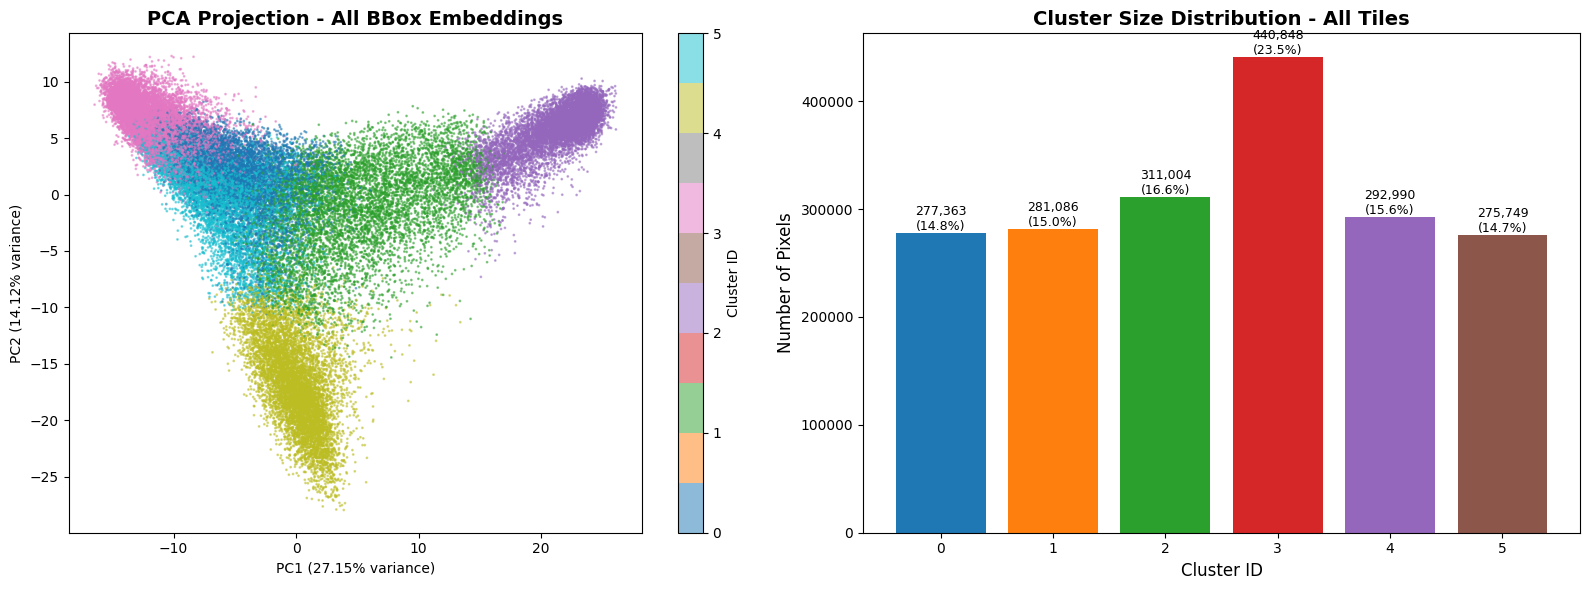


✓ Total explained variance (2 components): 41.27%


In [26]:
# PCA visualization and cluster statistics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: PCA projection with clusters
print("Performing PCA on all bbox embeddings...")
pca_bbox = PCA(n_components=2)

# Sample if too many points for visualization
max_points = 50000
if len(bbox_embeddings_all) > max_points:
    print(f"Sampling {max_points} points from {len(bbox_embeddings_all):,} for visualization...")
    sample_idx = np.random.choice(len(bbox_embeddings_all), max_points, replace=False)
    embeddings_sample = bbox_embeddings_all[sample_idx]
    labels_sample = cluster_labels_bbox[sample_idx]
else:
    embeddings_sample = bbox_embeddings_all
    labels_sample = cluster_labels_bbox

embeddings_2d_bbox = pca_bbox.fit_transform(embeddings_sample)

scatter = axes[0].scatter(embeddings_2d_bbox[:, 0], embeddings_2d_bbox[:, 1],
                          c=labels_sample, cmap='tab10',
                          alpha=0.5, s=1)
axes[0].set_title('PCA Projection - All BBox Embeddings', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca_bbox.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_bbox.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[0], label='Cluster ID')

# Plot 2: Cluster size distribution
cluster_counts_bbox = np.bincount(cluster_labels_bbox)
colors = plt.cm.tab10(np.arange(n_clusters_bbox))

bars = axes[1].bar(range(n_clusters_bbox), cluster_counts_bbox, color=colors)
axes[1].set_xlabel('Cluster ID', fontsize=12)
axes[1].set_ylabel('Number of Pixels', fontsize=12)
axes[1].set_title('Cluster Size Distribution - All Tiles', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(n_clusters_bbox))

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, cluster_counts_bbox)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({count/len(cluster_labels_bbox)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✓ Total explained variance (2 components): {sum(pca_bbox.explained_variance_ratio_):.2%}")